# ViT Transformer on CIFAR10 Dataset

## Libraries

In [1]:
import torch
import torchvision.datasets as datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms as tfs
from transformers import ViTForImageClassification, ViTConfig
#from tqdm.notebook import tqdm #for google colab
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device) # cuda?

Device: cuda:0


## Scratch ViT Transformer Model

### Load Data and Augmentations

In [2]:
def set_seed(seed):
    '''
    Load a random seed
    '''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_data(download_data, batch_size, image_size):
    '''
    Download CIFAR-10 Dataset into train and test splits. Create dataloaders for data.
    '''
    print("Downloading Dataset...")
    
    train_transform = tfs.Compose([
        tfs.ToTensor(),
        tfs.RandomHorizontalFlip(),
        tfs.RandomCrop(32, padding=4),
        tfs.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        tfs.Resize((image_size, image_size))
    ]) 
    test_transform = tfs.Compose([
        tfs.ToTensor(),
        tfs.Resize((image_size, image_size)),
        tfs.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]) 
                                 
    data_train = datasets.CIFAR10(root='./data', train=True, download=download_data, transform=train_transform)
    data_test = datasets.CIFAR10(root='./data', train=False, download=download_data, transform=test_transform)
    
    train_loader = DataLoader(data_train, batch_size=batch_size,shuffle=True, num_workers=2)
    test_loader = DataLoader(data_test, batch_size=batch_size,shuffle=False, num_workers=2)
    print("Dataset Downloaded!")
    
    return train_loader, test_loader

### Define a basic ViT Model

Uses configurable ViT function from HuggingFace. Changed the input image size and output class size to fit CIFAR10 data and also made the model smaller (less hidden layers) to speed up training for smaller images.

In [3]:
def create_ViTModel():
    '''
    Smaller Version of ViT model with accomodations for CIFAR-10 data
    '''
    image_size = 32 # image size
    patch_size = 4 # patch size for encoding
    num_classes = 10 # num of classes
    
    #ViT model for CIFAR-10
    config = ViTConfig(
        image_size=image_size,  # 224->32 Input image size
        patch_size=patch_size,  # 16->4 Patch size for the 32x32 images
        num_labels=num_classes,  # 1000->10 Number of output classes
        hidden_size=256,  # 768->256 Hidden size (smaller model for smaller images)
        num_hidden_layers=6,  # 12->6 Fewer layers, since the image size is smaller
        num_attention_heads=8,  # 12->8 Number of attention heads
        intermediate_size=512,  # 3072->512 Intermediate size of feedforward network
        hidden_dropout_prob=0.0,  # Dropout probability
        attention_probs_dropout_prob=0.0,  # Dropout on attention scores
    )
    
    model = ViTForImageClassification(config)
    
    return model

### Train and Test Model Functions

In [4]:
def train_model(train_data, test_data, model, optimizer, criterion, epochs):
    print("Starting Training...")
    model.train()
    batch_losses = []
    epoch_losses = []
    test_accuracies = []
    num_batches = len(train_data) # num of batches per epoch
    
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in tqdm(enumerate(train_data)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output.logits, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() #running loss for epoch loss            
                
        print(f'Epoch: {epoch + 1}, Average Training Loss: {running_loss/num_batches}' )
        # get average loss over epoch (scratch only)
        epoch_losses.append([epoch, running_loss/num_batches])
        accuracy, _ = test_model(test_data, model)
        test_accuracies.append(accuracy)
    
    print("Finished Training!")
    return model, batch_losses, epoch_losses, test_accuracies

In [5]:
def test_model(test_data, model):
    print("Testing Model...")
    correct = 0
    predictions = []
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_data)):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.logits, 1)
            predictions.append(predicted)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / 10000
    print(f'Test Accuracy: {accuracy}%' )
    
    return accuracy, predictions

In [6]:
# confusion matrix creator
def confusion_matrix(classes, predicted_vals, test_data):
    num_classes = len(classes)
    actuals = []
    predictions = []
    #need to unroll dataloader and predictions
    for idx, (_, labels) in enumerate(test_data):
        actuals.extend(labels.tolist())
        predictions.extend(predicted_vals[idx])

    #create matrix
    mat = np.zeros((num_classes, num_classes))
    #print(len(predictions), len(actuals))
    for prediction, actual in zip(predictions, actuals):
        mat[prediction,actual] += 1

    #plot matrix
    fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 10))
    ax1.matshow(mat)
    
    # add the title and label
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Actual Class')
    ax1.set_ylabel('Predicted Class')
    # set ticks to the classes
    ax1.set_xticks(np.arange(num_classes), labels=classes)
    ax1.set_yticks(np.arange(num_classes), labels=classes)

    for x in range(num_classes):
        for y in range(num_classes):
            ax1.annotate(int(mat[x,y]),xy=(x-0.2,y+0.1))
            


### Run Training from scratch model

In [7]:
# Get dataloaders
batch_size = 100
image_size = 32
# set download data to true if not downloaded already
train_loader, test_loader = get_data(download_data = False, batch_size = batch_size, image_size = image_size)

Dataset Downloaded!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1770618..2.6952004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.351526..2.6952004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2933714..1.908451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4096808..2.7537313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1035852..2.518123].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9444429..1.9342991].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2412531..

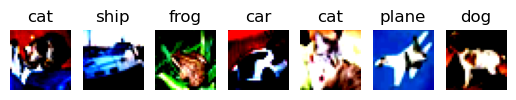

In [8]:
# Visualize images
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# hyperparameters
fig = plt.figure() 
images = next(iter(test_loader))
for i in range(7):
    fig.add_subplot(1, 7, i+1) 
    plt.imshow(images[0][2*i].permute(1, 2, 0))
    plt.axis('off') 
    plt.title(classes[images[1][2*i]]) 


In [9]:
# Main 
# set the random seed
seed = 42
set_seed(seed)
epochs = 40
lr = 1e-4
#model
model = create_ViTModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam 
criterion = nn.CrossEntropyLoss() 
# run training
trained_model, batch_losses, epoch_losses, test_accuracies = train_model(train_loader, test_loader, model, optimizer, criterion, epochs)

Starting Training...


0it [00:00, ?it/s]c:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\transformers\models\vit\modeling_vit.py:252: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
500it [00:59,  8.40it/s]


Epoch: 1, Average Training Loss: 1.7788601195812226
Testing Model...


100it [00:03, 28.85it/s]


Test Accuracy: 41.12%


500it [00:48, 10.22it/s]


Epoch: 2, Average Training Loss: 1.435203596830368
Testing Model...


100it [00:03, 26.88it/s]


Test Accuracy: 51.06%


500it [00:49, 10.04it/s]


Epoch: 3, Average Training Loss: 1.2614979430437088
Testing Model...


100it [00:03, 28.11it/s]


Test Accuracy: 57.0%


500it [00:48, 10.21it/s]


Epoch: 4, Average Training Loss: 1.1591008551120758
Testing Model...


100it [00:03, 26.47it/s]


Test Accuracy: 57.42%


500it [00:50,  9.97it/s]


Epoch: 5, Average Training Loss: 1.085102244734764
Testing Model...


100it [00:03, 26.63it/s]


Test Accuracy: 62.07%


500it [00:52,  9.45it/s]


Epoch: 6, Average Training Loss: 1.0219123470783233
Testing Model...


100it [00:03, 27.73it/s]


Test Accuracy: 64.83%


500it [00:53,  9.34it/s]


Epoch: 7, Average Training Loss: 0.9738837976455689
Testing Model...


100it [00:03, 28.48it/s]


Test Accuracy: 67.73%


500it [00:53,  9.35it/s]


Epoch: 8, Average Training Loss: 0.9227694236040115
Testing Model...


100it [00:03, 28.06it/s]


Test Accuracy: 67.2%


500it [00:53,  9.27it/s]


Epoch: 9, Average Training Loss: 0.8707098126411438
Testing Model...


100it [00:03, 28.62it/s]


Test Accuracy: 68.93%


500it [00:52,  9.47it/s]


Epoch: 10, Average Training Loss: 0.8369457297325135
Testing Model...


100it [00:03, 27.53it/s]


Test Accuracy: 70.75%


500it [00:54,  9.24it/s]


Epoch: 11, Average Training Loss: 0.8038960976600646
Testing Model...


100it [00:03, 27.09it/s]


Test Accuracy: 71.57%


500it [00:54,  9.20it/s]


Epoch: 12, Average Training Loss: 0.7656584465503693
Testing Model...


100it [00:03, 26.39it/s]


Test Accuracy: 72.14%


500it [00:54,  9.22it/s]


Epoch: 13, Average Training Loss: 0.7427107385396957
Testing Model...


100it [00:03, 28.32it/s]


Test Accuracy: 72.68%


500it [00:56,  8.93it/s]


Epoch: 14, Average Training Loss: 0.7063895908594131
Testing Model...


100it [00:03, 26.92it/s]


Test Accuracy: 74.9%


500it [00:55,  9.06it/s]


Epoch: 15, Average Training Loss: 0.690698114156723
Testing Model...


100it [00:03, 26.91it/s]


Test Accuracy: 72.99%


500it [00:56,  8.91it/s]


Epoch: 16, Average Training Loss: 0.6682174343466759
Testing Model...


100it [00:03, 25.81it/s]


Test Accuracy: 74.29%


500it [00:54,  9.22it/s]


Epoch: 17, Average Training Loss: 0.6441955996155739
Testing Model...


100it [00:03, 25.87it/s]


Test Accuracy: 76.23%


500it [00:56,  8.84it/s]


Epoch: 18, Average Training Loss: 0.6212761876583099
Testing Model...


100it [00:03, 26.67it/s]


Test Accuracy: 76.67%


500it [00:54,  9.14it/s]


Epoch: 19, Average Training Loss: 0.6002607713341713
Testing Model...


100it [00:03, 28.59it/s]


Test Accuracy: 76.96%


500it [00:54,  9.09it/s]


Epoch: 20, Average Training Loss: 0.5841266531944275
Testing Model...


100it [00:03, 27.03it/s]


Test Accuracy: 76.45%


500it [00:55,  9.03it/s]


Epoch: 21, Average Training Loss: 0.5661093810200691
Testing Model...


100it [00:03, 28.28it/s]


Test Accuracy: 76.92%


500it [00:55,  8.96it/s]


Epoch: 22, Average Training Loss: 0.5443105479478836
Testing Model...


100it [00:04, 24.87it/s]


Test Accuracy: 77.88%


500it [00:57,  8.65it/s]


Epoch: 23, Average Training Loss: 0.5297250992059708
Testing Model...


100it [00:03, 25.55it/s]


Test Accuracy: 77.72%


500it [00:55,  8.97it/s]


Epoch: 24, Average Training Loss: 0.508626264065504
Testing Model...


100it [00:03, 27.98it/s]


Test Accuracy: 78.63%


500it [00:55,  9.08it/s]


Epoch: 25, Average Training Loss: 0.4941293298602104
Testing Model...


100it [00:03, 26.94it/s]


Test Accuracy: 78.43%


500it [00:55,  8.95it/s]


Epoch: 26, Average Training Loss: 0.4798332377076149
Testing Model...


100it [00:03, 27.94it/s]


Test Accuracy: 76.42%


500it [00:55,  8.95it/s]


Epoch: 27, Average Training Loss: 0.4567517488002777
Testing Model...


100it [00:03, 26.55it/s]


Test Accuracy: 78.3%


500it [00:53,  9.36it/s]


Epoch: 28, Average Training Loss: 0.45092562824487686
Testing Model...


100it [00:03, 28.33it/s]


Test Accuracy: 79.68%


500it [00:51,  9.71it/s]


Epoch: 29, Average Training Loss: 0.42978142020106314
Testing Model...


100it [00:03, 27.16it/s]


Test Accuracy: 79.91%


500it [00:51,  9.76it/s]


Epoch: 30, Average Training Loss: 0.4150242710709572
Testing Model...


100it [00:03, 27.01it/s]


Test Accuracy: 78.54%


500it [00:51,  9.78it/s]


Epoch: 31, Average Training Loss: 0.4032616263628006
Testing Model...


100it [00:03, 27.24it/s]


Test Accuracy: 79.59%


500it [00:53,  9.29it/s]


Epoch: 32, Average Training Loss: 0.3846920526623726
Testing Model...


100it [00:03, 27.35it/s]


Test Accuracy: 79.23%


500it [00:53,  9.28it/s]


Epoch: 33, Average Training Loss: 0.373200883358717
Testing Model...


100it [00:03, 27.13it/s]


Test Accuracy: 79.59%


500it [00:53,  9.28it/s]


Epoch: 34, Average Training Loss: 0.3589352248311043
Testing Model...


100it [00:03, 26.93it/s]


Test Accuracy: 79.81%


500it [00:53,  9.28it/s]


Epoch: 35, Average Training Loss: 0.3420868677794933
Testing Model...


100it [00:03, 26.52it/s]


Test Accuracy: 79.62%


500it [00:54,  9.24it/s]


Epoch: 36, Average Training Loss: 0.329080348521471
Testing Model...


100it [00:03, 27.06it/s]


Test Accuracy: 79.83%


500it [00:51,  9.66it/s]


Epoch: 37, Average Training Loss: 0.3167169889509678
Testing Model...


100it [00:03, 28.43it/s]


Test Accuracy: 79.95%


500it [00:51,  9.63it/s]


Epoch: 38, Average Training Loss: 0.30500979387760163
Testing Model...


100it [00:03, 27.68it/s]


Test Accuracy: 80.4%


500it [00:51,  9.76it/s]


Epoch: 39, Average Training Loss: 0.2922238664329052
Testing Model...


100it [00:03, 28.06it/s]


Test Accuracy: 80.23%


500it [00:51,  9.71it/s]


Epoch: 40, Average Training Loss: 0.2737396823167801
Testing Model...


100it [00:03, 28.75it/s]

Test Accuracy: 80.14%
Finished Training!


### Evaluate Model

Run test set on trained model and get loss and accuracy plots

In [10]:
# evaluate model on test set
final_accuracy, predictions = test_model(test_loader, trained_model)

Testing Model...


100it [00:03, 28.87it/s]

Test Accuracy: 80.14%


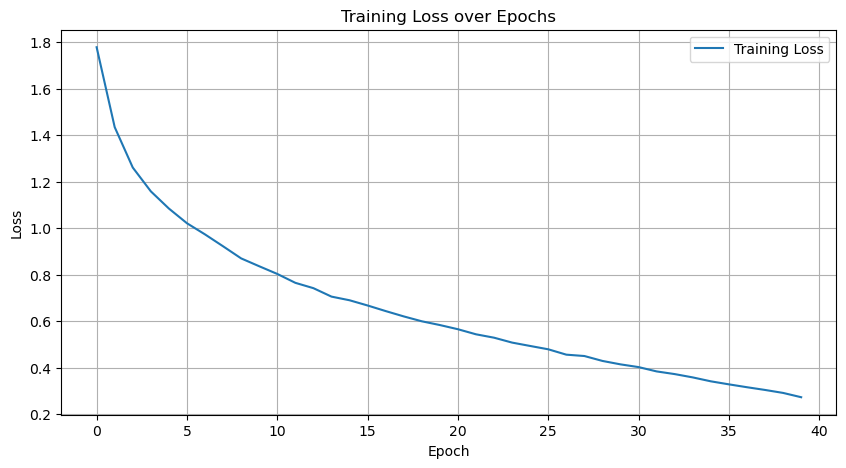

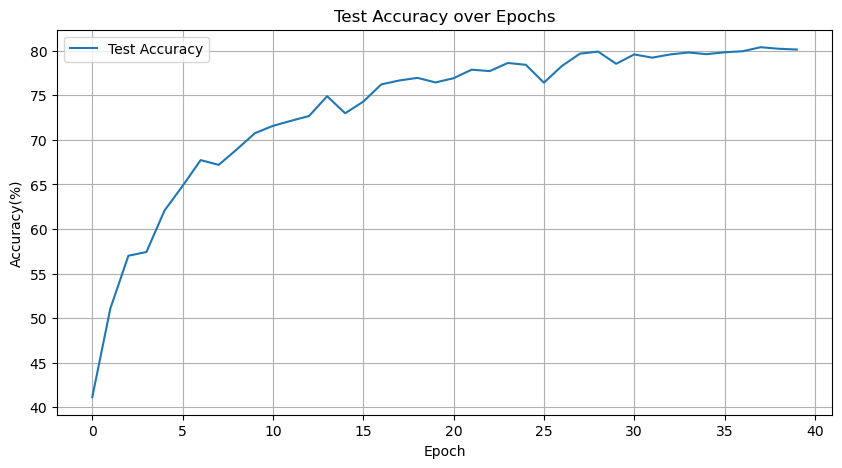

In [12]:
#Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(epoch_losses)[:,0], np.array(epoch_losses)[:,1], label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.array(epoch_losses)[:,0], np.array(test_accuracies), label='Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.grid(True)
plt.show()


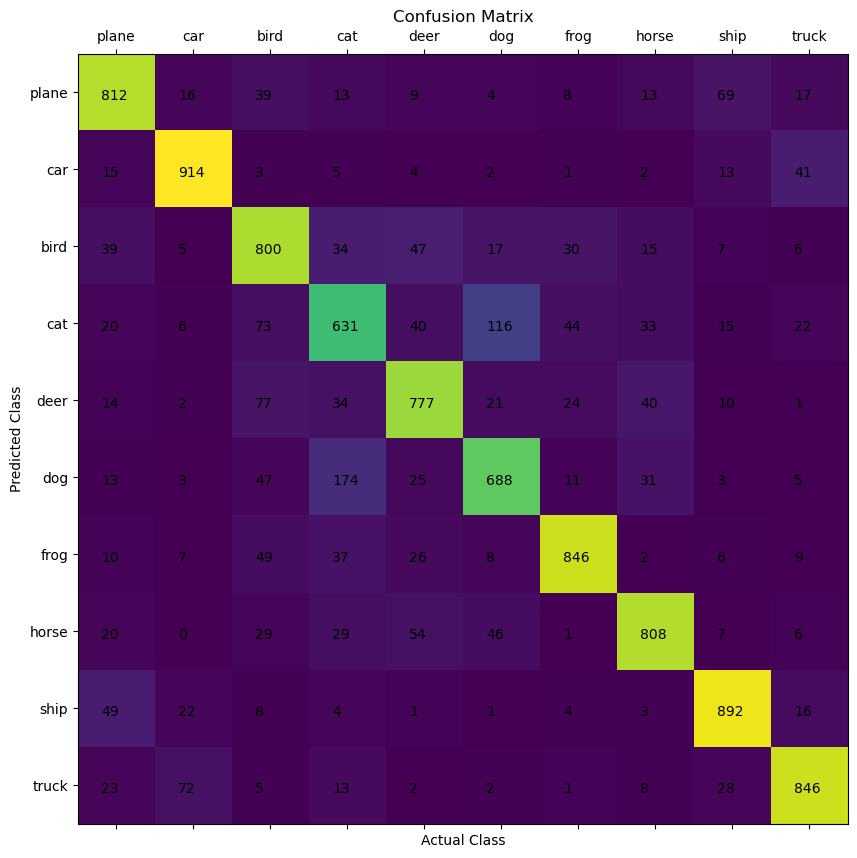

In [73]:
# Confusion matrix
confusion_matrix(classes, predictions, test_loader)

## Pre-Trained ViT Transformer Model

### Run training for pre-trained ViT Model

Use HuggingFace to load the tiny ViT model from its paper with its weights trained on ImageNet

In [13]:
# training for pretrained
def train_model(train_data, test_data, model, optimizer, criterion, epochs):
    print("Starting Training...")
    model.train()
    batch_losses = []
    epoch_losses = []
    test_accuracies = []
    num_batches = len(train_data) # num of batches per epoch
    
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in tqdm(enumerate(train_data)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output.logits, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() #running loss for epoch loss

            # Output batch loss every 100 epochs (pretrained only)
            if (batch_idx) % 100 == 0:
                total_batch = (batch_idx+1 + (epoch)*num_batches) # batch number over epochs
                # print batch loss
                print(f'Batch {batch_idx} Loss: {loss.item()}')
                batch_losses.append([total_batch, loss.item()])
                # Get test accuracy at this step
                accuracy, _ = test_model(test_data, model)
                test_accuracies.append(accuracy)
                
        print(f'Epoch: {epoch + 1}, Average Training Loss: {running_loss/num_batches}' )
    
    print("Finished Training!")
    return model, batch_losses, epoch_losses, test_accuracies

In [14]:
# pre trained tiny ViT weights but remove the last layer and output to the 10 CIFAR classes
model = ViTForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224",num_labels=10, ignore_mismatched_sizes=True).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Get dataloaders
batch_size = 20
image_size = 224
# set download data to true if not downloaded already
train_loader, test_loader = get_data(download_data = False, batch_size = batch_size, image_size = image_size)

Dataset Downloaded!


In [16]:
# Main 
# set the random seed
seed = 42
set_seed(seed)
# hyperparameters
epochs = 2   
lr = 3e-6
#model
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam 
criterion = nn.CrossEntropyLoss() 
# run training
trained_model_pre, batch_losses_pre, epoch_losses_pre, test_accuracies_pre = train_model(train_loader, test_loader, model, optimizer, criterion, epochs)

Starting Training...


0it [00:00, ?it/s]

Batch 0 Loss: 2.677405834197998
Testing Model...


500it [00:18, 26.50it/s]
3it [00:27,  7.05s/it]

Test Accuracy: 13.14%


99it [00:36, 10.73it/s]

Batch 100 Loss: 1.961197853088379
Testing Model...


500it [00:19, 25.73it/s]
102it [01:04,  3.51s/it]

Test Accuracy: 25.13%


200it [01:13, 10.66it/s]

Batch 200 Loss: 1.626806616783142
Testing Model...


500it [00:19, 25.20it/s]
202it [01:42,  4.13s/it]

Test Accuracy: 41.4%


299it [01:51, 10.46it/s]

Batch 300 Loss: 1.4656877517700195
Testing Model...


500it [00:19, 25.26it/s]
302it [02:20,  3.61s/it]

Test Accuracy: 54.56%


400it [02:29, 10.17it/s]

Batch 400 Loss: 1.105992317199707
Testing Model...


500it [00:20, 24.95it/s]
403it [02:58,  3.45s/it]

Test Accuracy: 63.66%


499it [03:08, 10.02it/s]

Batch 500 Loss: 0.9578126072883606
Testing Model...


500it [00:21, 23.73it/s]
503it [03:38,  3.07s/it]

Test Accuracy: 71.02%


599it [03:48,  9.85it/s]

Batch 600 Loss: 0.7189499139785767
Testing Model...


500it [00:20, 23.95it/s]
603it [04:18,  3.85s/it]

Test Accuracy: 75.57%


699it [04:28, 10.01it/s]

Batch 700 Loss: 0.6297649145126343
Testing Model...


500it [00:20, 24.24it/s]
702it [04:58,  4.14s/it]

Test Accuracy: 78.87%


800it [05:07,  9.94it/s]

Batch 800 Loss: 0.5357763767242432
Testing Model...


500it [00:20, 23.99it/s]
802it [05:38,  5.06s/it]

Test Accuracy: 81.31%


900it [05:48,  9.80it/s]

Batch 900 Loss: 0.5381147861480713
Testing Model...


500it [00:21, 23.74it/s]
902it [06:18,  6.30s/it]

Test Accuracy: 83.6%


1000it [06:28,  9.67it/s]

Batch 1000 Loss: 0.411135196685791
Testing Model...


500it [00:21, 23.66it/s]
1002it [06:58,  6.34s/it]

Test Accuracy: 84.91%


1100it [07:08,  9.64it/s]

Batch 1100 Loss: 0.20155389606952667
Testing Model...


500it [00:21, 23.54it/s]
1102it [07:38,  6.37s/it]

Test Accuracy: 86.2%


1200it [07:49,  9.64it/s]

Batch 1200 Loss: 0.5780350565910339
Testing Model...


500it [00:21, 23.55it/s]
1202it [08:19,  6.41s/it]

Test Accuracy: 87.41%


1300it [08:29,  9.69it/s]

Batch 1300 Loss: 0.5122131705284119
Testing Model...


500it [00:21, 23.54it/s]
1302it [08:59,  6.34s/it]

Test Accuracy: 88.0%


1400it [09:09,  9.60it/s]

Batch 1400 Loss: 0.4504185616970062
Testing Model...


500it [00:21, 23.71it/s]
1402it [09:39,  6.38s/it]

Test Accuracy: 89.1%


1500it [09:50,  9.73it/s]

Batch 1500 Loss: 0.49496132135391235
Testing Model...


500it [00:22, 22.46it/s]
1502it [10:20,  6.54s/it]

Test Accuracy: 89.33%


1600it [10:31,  9.34it/s]

Batch 1600 Loss: 0.38603320717811584
Testing Model...


500it [00:22, 22.41it/s]
1602it [11:03,  6.68s/it]

Test Accuracy: 90.16%


1700it [11:13,  9.25it/s]

Batch 1700 Loss: 0.12657998502254486
Testing Model...


500it [00:22, 22.54it/s]
1702it [11:45,  6.69s/it]

Test Accuracy: 90.62%


1800it [11:56,  9.34it/s]

Batch 1800 Loss: 0.34647995233535767
Testing Model...


500it [00:22, 22.45it/s]
1802it [12:27,  6.73s/it]

Test Accuracy: 91.08%


1900it [12:38,  9.40it/s]

Batch 1900 Loss: 0.23824162781238556
Testing Model...


500it [00:22, 22.63it/s]
1902it [13:09,  6.67s/it]

Test Accuracy: 91.14%


2000it [13:20,  9.26it/s]

Batch 2000 Loss: 0.4165768623352051
Testing Model...


500it [00:22, 21.93it/s]
2002it [13:54,  7.11s/it]

Test Accuracy: 91.63%


2100it [14:05,  9.45it/s]

Batch 2100 Loss: 0.22959132492542267
Testing Model...


500it [00:21, 22.78it/s]
2102it [14:37,  6.72s/it]

Test Accuracy: 91.88%


2199it [14:49,  4.11it/s]

Batch 2200 Loss: 0.28385376930236816
Testing Model...


500it [00:21, 23.02it/s]
2202it [15:19,  5.38s/it]

Test Accuracy: 92.1%


2300it [15:30,  6.18it/s]

Batch 2300 Loss: 0.2540469765663147
Testing Model...


500it [00:22, 22.02it/s]
2302it [16:02,  5.99s/it]

Test Accuracy: 92.43%


2400it [16:13,  9.29it/s]

Batch 2400 Loss: 0.21157848834991455
Testing Model...


500it [00:23, 21.71it/s]
2402it [16:46,  6.95s/it]

Test Accuracy: 92.46%


2500it [16:58,  2.45it/s]


Epoch: 1, Average Training Loss: 0.6539594037637114


0it [00:00, ?it/s]

Batch 0 Loss: 0.1661997139453888
Testing Model...


500it [00:23, 21.64it/s]
2it [00:33, 13.72s/it]

Test Accuracy: 92.8%


100it [00:44,  9.06it/s]

Batch 100 Loss: 0.3490656912326813
Testing Model...


500it [00:22, 21.86it/s]
102it [01:17,  6.96s/it]

Test Accuracy: 92.6%


200it [01:28,  9.21it/s]

Batch 200 Loss: 0.19282330572605133
Testing Model...


500it [00:22, 22.20it/s]
202it [02:01,  7.01s/it]

Test Accuracy: 93.05%


300it [02:13,  9.32it/s]

Batch 300 Loss: 0.08601891249418259
Testing Model...


500it [00:22, 22.04it/s]
302it [02:45,  6.87s/it]

Test Accuracy: 92.8%


400it [02:58,  8.76it/s]

Batch 400 Loss: 0.09042651951313019
Testing Model...


500it [00:22, 22.08it/s]
402it [03:30,  6.77s/it]

Test Accuracy: 93.32%


500it [03:42,  7.64it/s]

Batch 500 Loss: 0.15808379650115967
Testing Model...


500it [00:22, 21.84it/s]
502it [04:15,  6.96s/it]

Test Accuracy: 93.36%


600it [04:28,  9.04it/s]

Batch 600 Loss: 0.26643308997154236
Testing Model...


500it [00:23, 21.40it/s]
602it [05:02,  7.13s/it]

Test Accuracy: 93.51%


700it [05:14,  8.24it/s]

Batch 700 Loss: 0.0777653306722641
Testing Model...


500it [00:22, 21.96it/s]
702it [05:47,  6.79s/it]

Test Accuracy: 93.7%


800it [05:59,  8.27it/s]

Batch 800 Loss: 0.32011616230010986
Testing Model...


500it [00:22, 22.29it/s]
802it [06:31,  5.83s/it]

Test Accuracy: 93.5%


900it [06:43,  9.08it/s]

Batch 900 Loss: 0.07271907478570938
Testing Model...


500it [00:22, 22.09it/s]
902it [07:16,  6.94s/it]

Test Accuracy: 93.76%


1000it [07:28,  9.30it/s]

Batch 1000 Loss: 0.2823292911052704
Testing Model...


500it [00:22, 21.93it/s]
1002it [08:02,  7.05s/it]

Test Accuracy: 93.92%


1100it [08:13,  9.36it/s]

Batch 1100 Loss: 0.3169822096824646
Testing Model...


500it [00:23, 21.71it/s]
1102it [08:47,  7.05s/it]

Test Accuracy: 94.21%


1200it [08:59,  8.98it/s]

Batch 1200 Loss: 0.21713736653327942
Testing Model...


500it [00:22, 21.92it/s]
1202it [09:32,  6.99s/it]

Test Accuracy: 93.99%


1300it [09:45,  8.33it/s]

Batch 1300 Loss: 0.272929847240448
Testing Model...


500it [00:22, 22.00it/s]
1302it [10:18,  7.03s/it]

Test Accuracy: 94.09%


1400it [10:30,  9.30it/s]

Batch 1400 Loss: 0.15315230190753937
Testing Model...


500it [00:22, 22.18it/s]
1402it [11:02,  6.87s/it]

Test Accuracy: 94.35%


1500it [11:15,  9.14it/s]

Batch 1500 Loss: 0.21733684837818146
Testing Model...


500it [00:23, 21.70it/s]
1502it [11:48,  7.08s/it]

Test Accuracy: 94.07%


1600it [12:01,  5.14it/s]

Batch 1600 Loss: 0.06718359142541885
Testing Model...


500it [00:22, 21.79it/s]
1602it [12:33,  6.99s/it]

Test Accuracy: 94.58%


1700it [12:46,  9.31it/s]

Batch 1700 Loss: 0.32216328382492065
Testing Model...


500it [00:22, 21.86it/s]
1702it [13:19,  6.98s/it]

Test Accuracy: 94.3%


1800it [13:32,  8.93it/s]

Batch 1800 Loss: 0.2949790060520172
Testing Model...


500it [00:22, 21.76it/s]
1802it [14:04,  6.97s/it]

Test Accuracy: 94.79%


1900it [14:17,  9.14it/s]

Batch 1900 Loss: 0.05496906489133835
Testing Model...


500it [00:23, 21.35it/s]
1902it [14:52,  7.38s/it]

Test Accuracy: 94.77%


2000it [15:04,  9.47it/s]

Batch 2000 Loss: 0.3603861927986145
Testing Model...


500it [00:22, 22.71it/s]
2002it [15:36,  6.72s/it]

Test Accuracy: 94.67%


2100it [15:48,  9.46it/s]

Batch 2100 Loss: 0.20734183490276337
Testing Model...


500it [00:22, 22.62it/s]
2102it [16:19,  6.75s/it]

Test Accuracy: 94.74%


2200it [16:31,  9.51it/s]

Batch 2200 Loss: 0.056274205446243286
Testing Model...


500it [00:22, 22.63it/s]
2203it [17:03,  5.14s/it]

Test Accuracy: 94.76%


2299it [17:14,  5.04it/s]

Batch 2300 Loss: 0.45622047781944275
Testing Model...


500it [00:22, 22.54it/s]
2302it [17:46,  5.57s/it]

Test Accuracy: 94.87%


2400it [17:57,  9.48it/s]

Batch 2400 Loss: 0.10790052264928818
Testing Model...


500it [00:22, 22.26it/s]
2402it [18:29,  6.84s/it]

Test Accuracy: 95.13%


2500it [18:42,  2.23it/s]

Epoch: 2, Average Training Loss: 0.1843070081539452
Finished Training!


### Evaluate Model

Run test set on trained model and get loss and accuracy plots

In [39]:
# evaluate model on test set
final_accuracy_pre, predictions_pre = test_model(test_loader, trained_model_pre)

Testing Model...


0it [00:00, ?it/s]

Test Accuracy: 94.49%


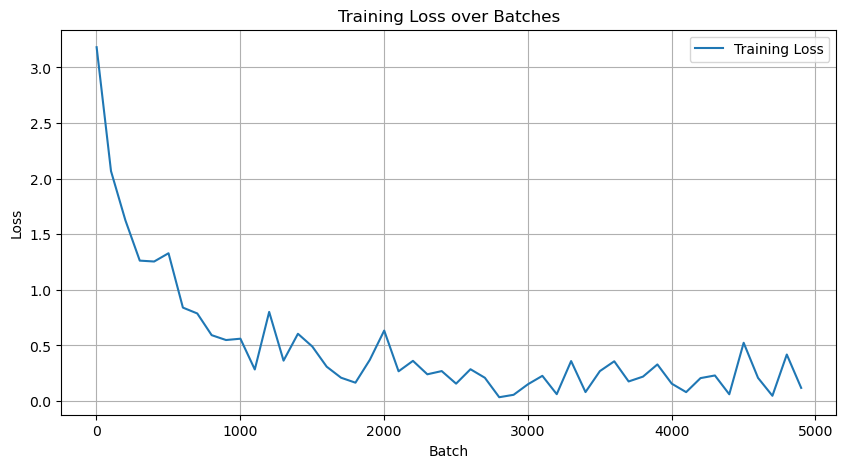

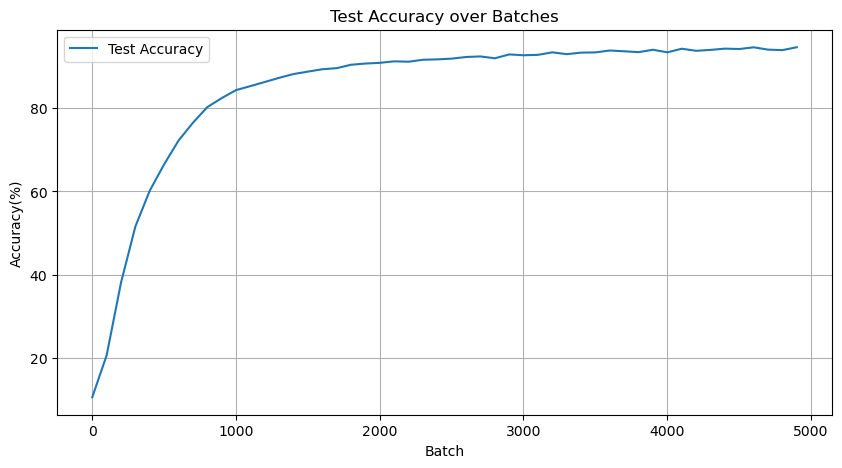

In [40]:
#Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(batch_losses_pre)[:,0], np.array(batch_losses_pre)[:,1], label='Training Loss')
plt.title('Training Loss over Batches')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.array(batch_losses_pre)[:,0], np.array(test_accuracies_pre), label='Test Accuracy')
plt.title('Test Accuracy over Batches')
plt.xlabel('Batch')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.grid(True)
plt.show()


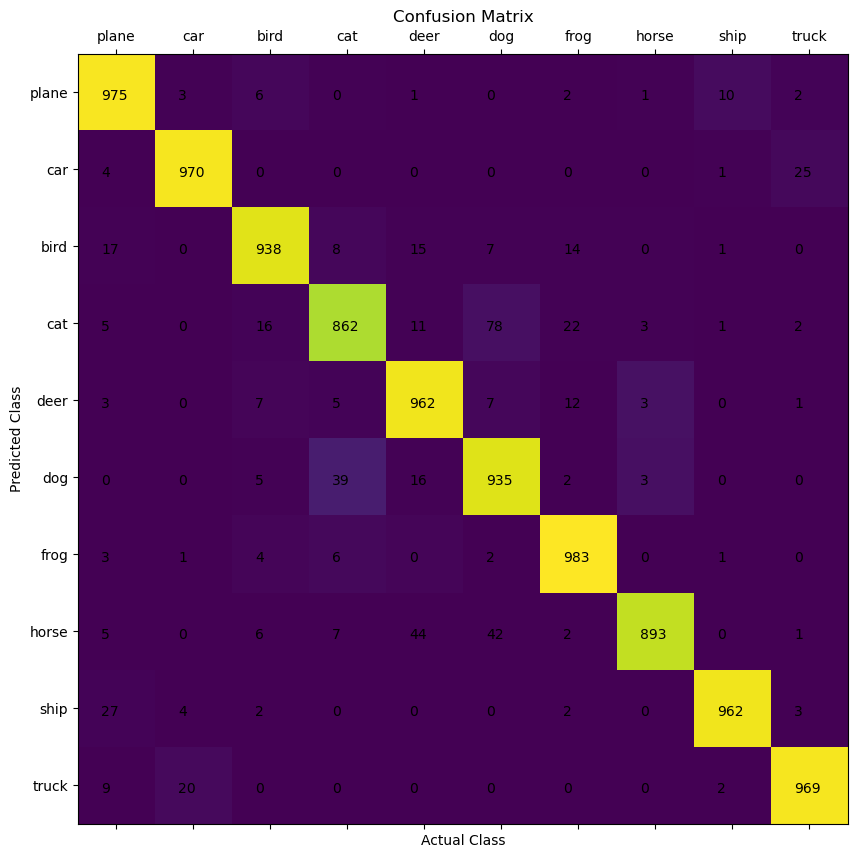

In [75]:
# Confusion matrix
confusion_matrix(classes, predictions_pre, test_loader)

## Adversarial Attack on Scratch Trained ViT using FGSM

In [91]:
# FGSM attack code
def fgsm_attack(image, epsilon, grad):
    # Collect the element-wise sign of the gradients
    sign_grad = grad.sign()
    # Create the attack image
    noisy_image = image + epsilon*sign_grad
    # clip to [0,1], toTensor scales images to [0,1]
    noisy_image = torch.clamp(noisy_image, 0, 1)

    return noisy_image

# restores the tensors to their original scale

def denorm(batch, mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [147]:
seed = 42
set_seed(seed)
# model to attack
attack_model = trained_model
criterion = nn.CrossEntropyLoss() 
epsilons = [0, .001, .005, .01, .05] # noise magnitudes for FGSM, 0 = no noise
# Get dataloaders
batch_size = 1
image_size = 32
# set download data to true if not downloaded already
train_loader, test_loader = get_data(download_data = False, batch_size = batch_size, image_size = image_size)

Dataset Downloaded!


In [148]:
def test(model, device, criterion, test_data, epsilon ):
    print("Testing Model Epsilon =", epsilon, "...")
    correct = 0
    adv_examples = []
    
    for batch_idx, (data, target) in tqdm(enumerate(test_data)):
        data, target = data.to(device), target.to(device)
        data.requires_grad = True # need grads for attack
        output = model(data)
        _, init_pred = torch.max(output.logits, 1)
        # If the initial prediction is wrong, dont attack
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = criterion(output.logits, target)
        # get grad
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        # FGSM attack
        data_denorm = denorm(data)
        noisy_image = fgsm_attack(data_denorm, epsilon, data_grad)
        noisy_image_norm = tfs.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(noisy_image)
        # Re-classify the noisy image
        output = model(noisy_image_norm)

        # Check for success
        _, final_pred = torch.max(output.logits, 1)
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = noisy_image.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = noisy_image.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {final_acc * 100}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

### FGSM Attack Results

I ran 5 different noise magnitude values (epsilons) for the FGSM attack. 0 corresponds with running the model with no attack as a baseline. The accuracy results and example images from each epsilon run can be found below.

In [149]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(attack_model, device, criterion, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Testing Model Epsilon = 0 ...


0it [00:00, ?it/s]

Epsilon: 0	Test Accuracy = 80.14
Testing Model Epsilon = 0.001 ...


0it [00:00, ?it/s]

Epsilon: 0.001	Test Accuracy = 71.45
Testing Model Epsilon = 0.005 ...


0it [00:00, ?it/s]

Epsilon: 0.005	Test Accuracy = 36.7
Testing Model Epsilon = 0.01 ...


0it [00:00, ?it/s]

Epsilon: 0.01	Test Accuracy = 12.889999999999999
Testing Model Epsilon = 0.05 ...


0it [00:00, ?it/s]

Epsilon: 0.05	Test Accuracy = 0.38999999999999996


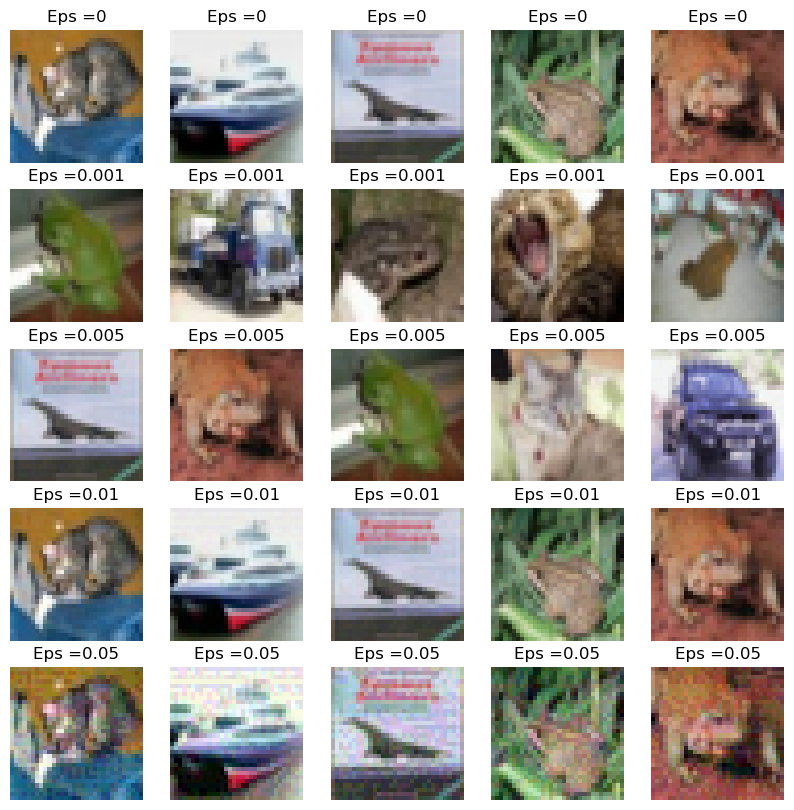

In [150]:
# show noisy images examples
fig = plt.figure(figsize=(10, 10))

for i in range(5): #loop through espilon
    for j in range(5): #loop through images
        fig.add_subplot(5, 5, (5*i)+j+1)
        plt.imshow(torch.from_numpy(examples[i][j][2]).permute(1, 2, 0))
        plt.axis('off') 
        plt.title("Eps =" + str(epsilons[i]))

